In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from utils import set_plots_size_params, plot_overview 

In [2]:
freqs = pd.read_csv('loop_freqs.csv')

In [3]:
freqs.shape

(193100, 8)

In [4]:
freqs.groupby('File').Read_count.mean()

File
p10-km1.freqs     2039.805321
p10-km2.freqs     1598.280887
p10-km3.freqs     3828.880952
p3-km1           10979.864724
p3-km1.freqs      1821.680434
p3-km2.freqs      3397.971728
p3-km3.freqs      3400.860711
p7-km1.freqs      5442.029774
p7-km2.freqs      3295.625659
p7-km3.freqs      1907.024668
Name: Read_count, dtype: float64

In [5]:
freqs = freqs[freqs.File!='p3-km1'].copy()  # drop the weird one..

In [6]:
freqs['File'].value_counts()

p7-km1.freqs     19480
p3-km3.freqs     19420
p3-km1.freqs     19370
p10-km3.freqs    19320
p3-km2.freqs     19100
p10-km1.freqs    18980
p7-km2.freqs     18980
p7-km3.freqs     18850
p10-km2.freqs    18495
Name: File, dtype: int64

In [7]:
freqs['km'] = freqs.File.map(lambda string: string.split(".")[0].split("-")[1].replace("km","")).astype(int)

In [8]:
freqs['passage'] = freqs.File.map(lambda string: string.split(".")[0].split("-")[0].replace("p","")).astype(int)

In [9]:
freqs.sort_values(by=['km', 'passage', 'Pos'], inplace=True)

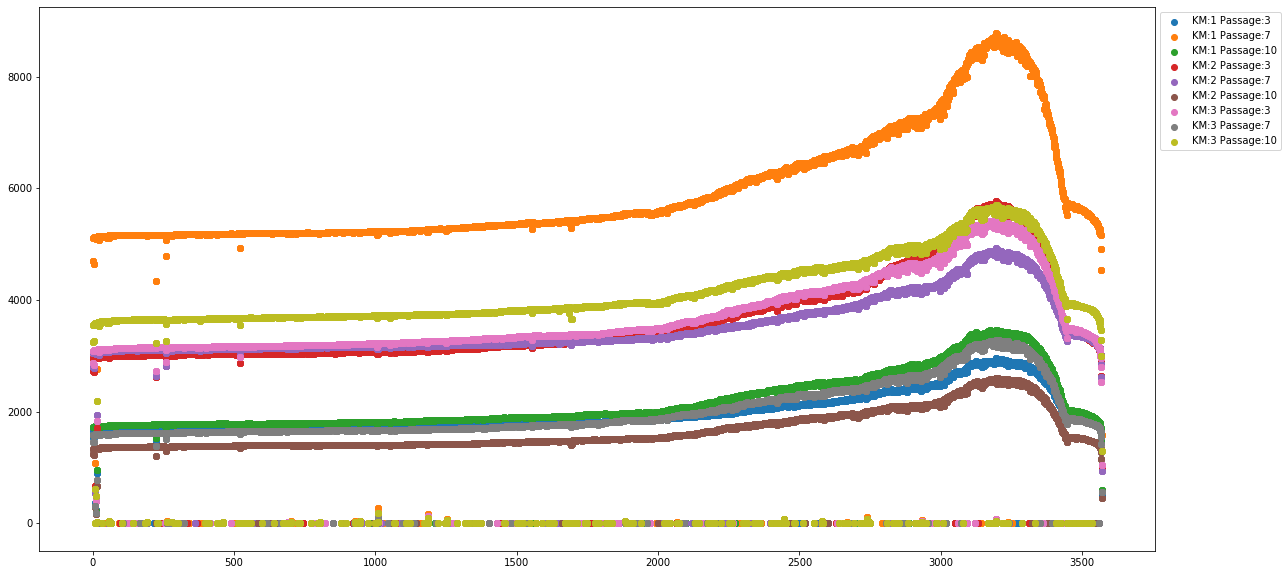

In [10]:
plt.figure(figsize=(20, 10))
for km in freqs.km.unique():
    for pas in freqs.passage.unique():
        df = freqs[freqs.km==km]
        df = df[df.passage==pas]
        plt.scatter(df.Pos, df.Read_count, label=f"KM:{km} Passage:{pas}")
plt.legend(bbox_to_anchor=(1, 1))
#plt.savefig('loop_coverage.png')

Getting Mutation Data...
Creating graphs!


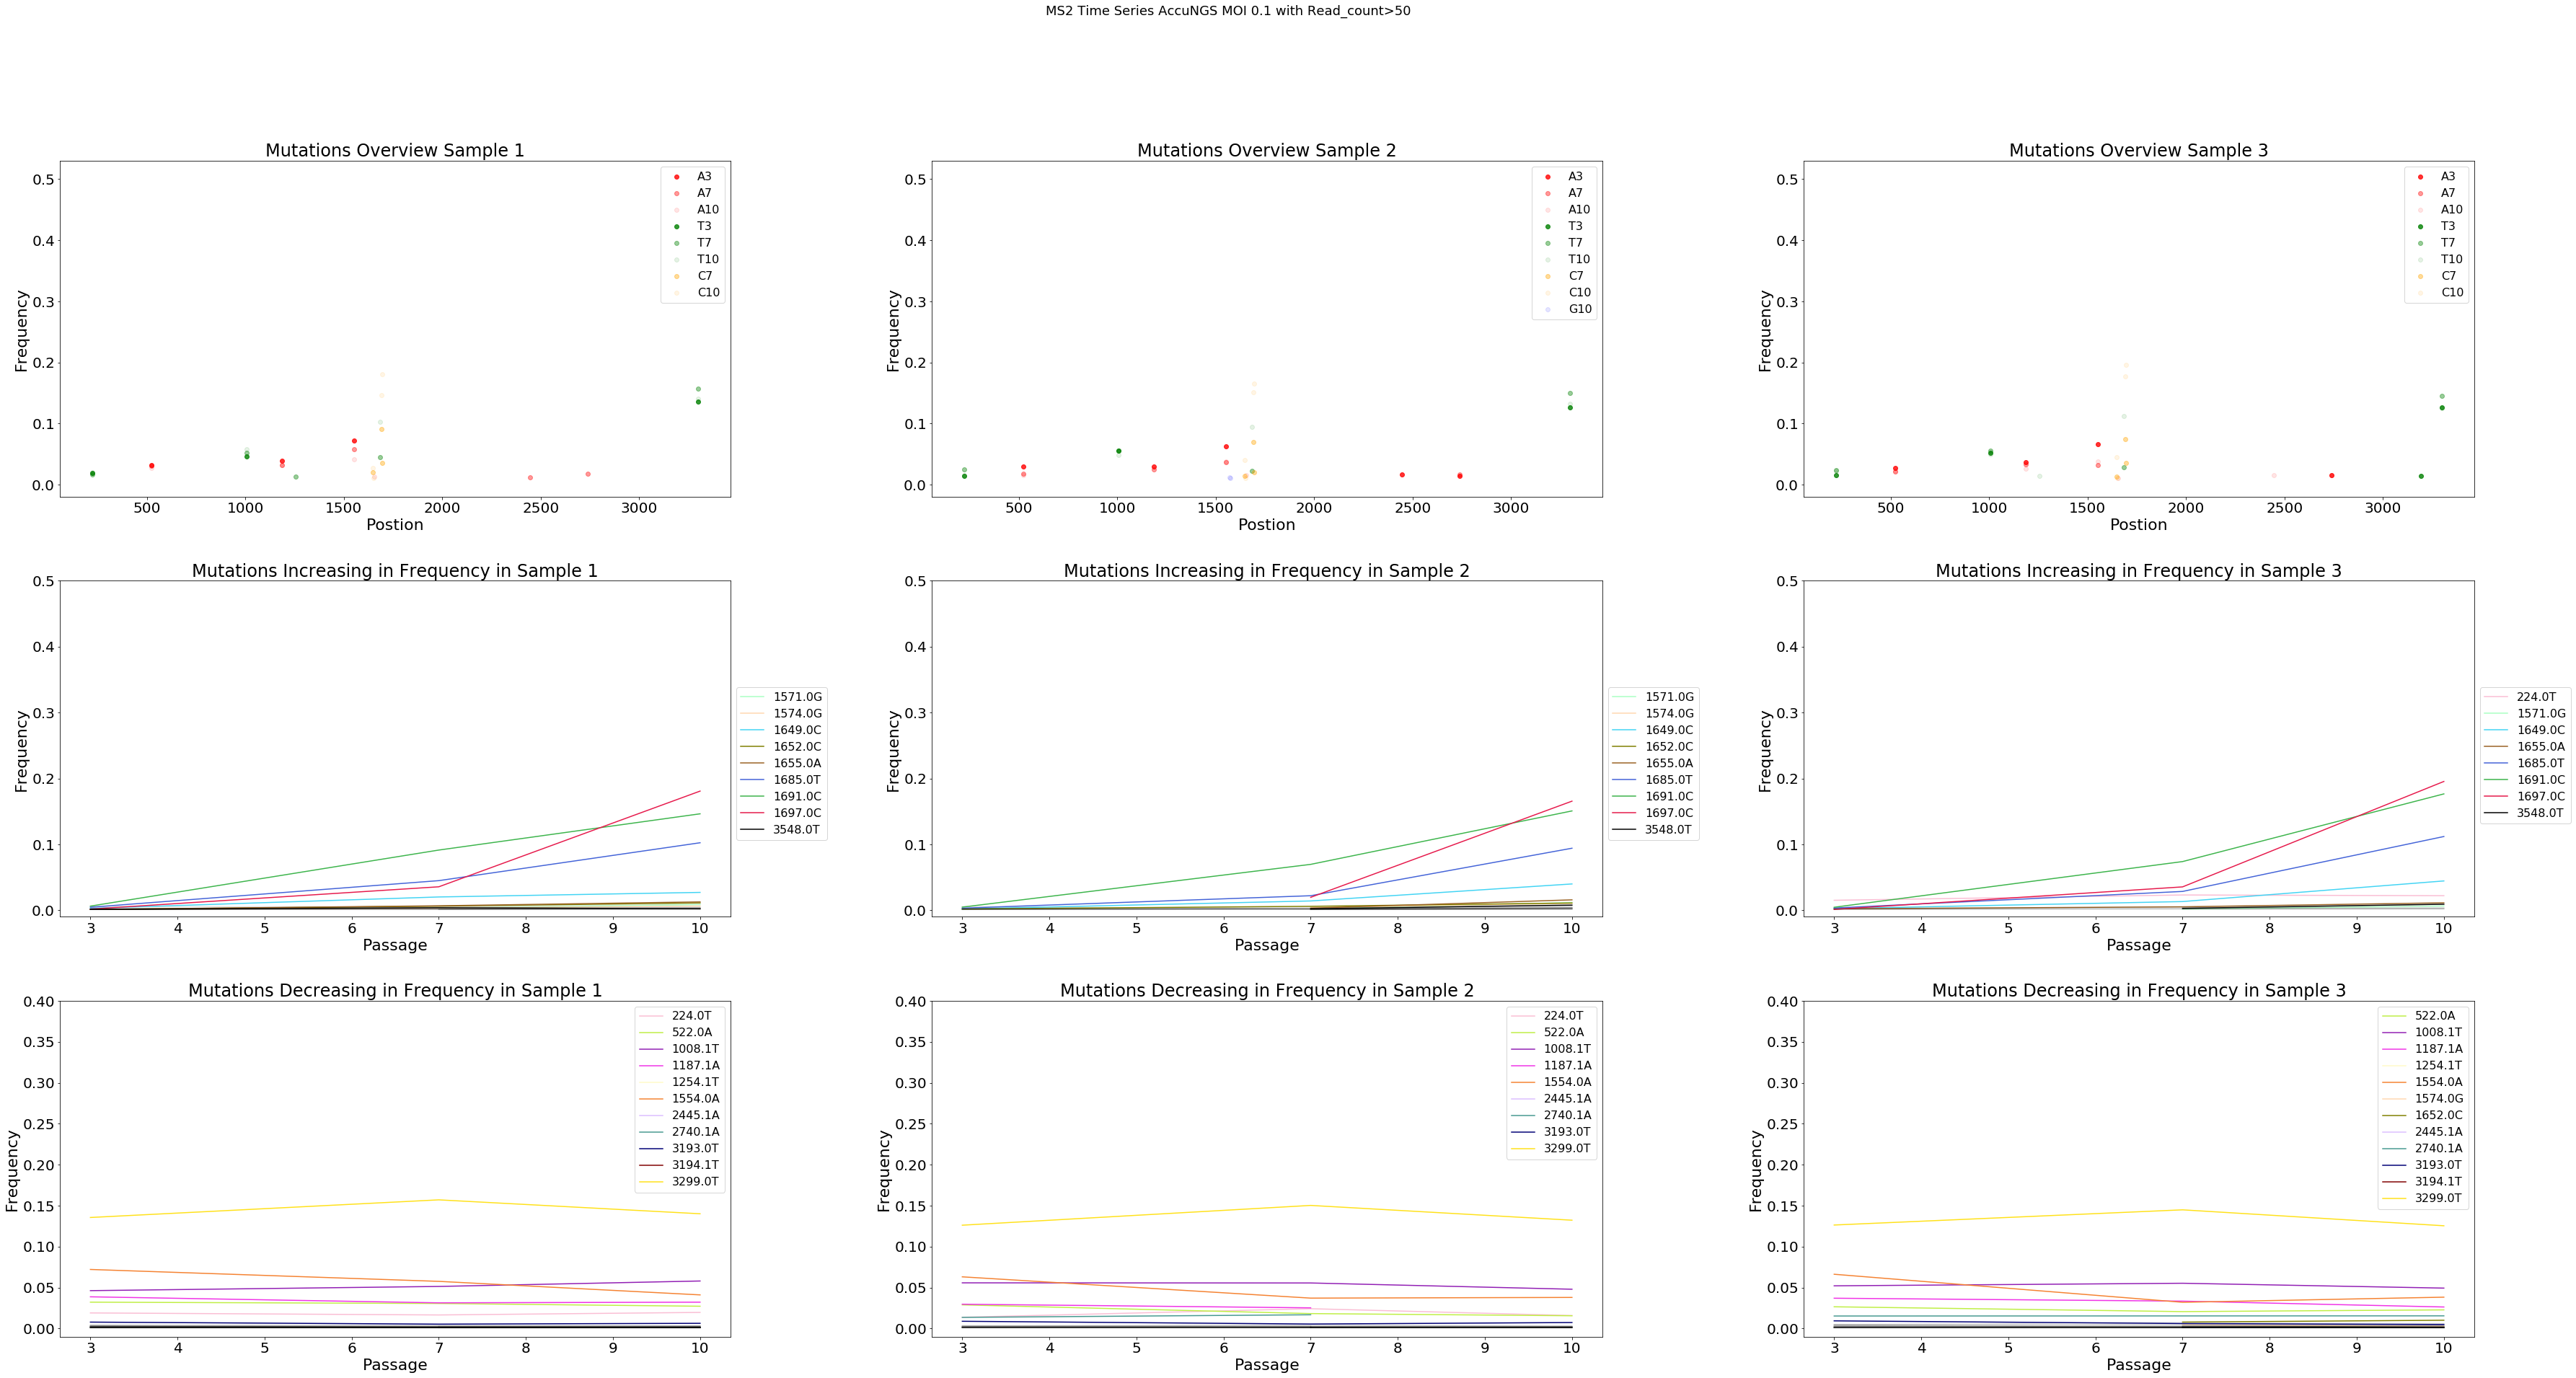

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [11]:
set_plots_size_params(20)
fig, axes = plot_overview(freqs)
#fig.savefig('loop_overview.png')